In [1]:
# Run this cell
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline
import re
import nltk
import string
# run this in cmd to avoid an error beforehand for this import
# python -m nltk.downloader stopwords punkt
from nltk.corpus import stopwords

import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


C:\Users\akani\AppData\Local\Temp\ipykernel_44664\3515081970.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [3]:
df = pd.read_csv('train.csv')
df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda text: remove_urls(text))
df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [4]:
def randNoun(lines):
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    if (len(nouns) == 0): # if no nouns picked up return rand word in text
        return lines[random.randrange(len(lines))]
    return nouns[random.randrange(len(nouns))]

In [5]:
# preprocessing of the dataset
print(len(df["location"]))
words = {} # will hold unique keywords
count = 0
# getting rid of %20 in keyword and getting a list of all the unqiue keywords
for i in df["keyword"]:
    i = str(i).replace("%20", ' ')
    if (i not in words.keys() and i != "nan"):
        words[i] = count
        count+=1

# filling in missing feature values
# missing keywords get filled in with a keywords already in "words" if that keyword shows up in text, otherwise pick a random word from text
# Missing "location" gets filled in with "Earth"
for i,j in df.iterrows():
    if (pd.isna(j["keyword"])):
        for k in words.keys():
            if k in j["text"]:
                df.at[i, "keyword"] = k
            else:
                df.at[i, "keyword"] = randNoun(j["text"])
    if (pd.isna(j["location"])):
        df.at[i, "location"] = "Earth"
# for i, j in df.iterrows():
#     if (pd.isna(j["location"])):
#         df.drop(i, axis=0, inplace=True)


for i,j in df.iterrows():
    if (df.at[i, "target"] == 0):
        df.at[i, "target"] = -1

7613


In [6]:
# we are going to feature transform 
corpus = df["text"].to_list() # combine all text to a bag of words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray() # TF-IDF text encoding

#doing hot and cold encoding for keywords
words = {} # will hold unique keywords with a corresponding index
count = 0
for i in df["keyword"]:
    if (i not in words.keys()):
        words[i] = count
        count+=1
# print(words)
keywords_hot_cold = np.zeros((len(df["keyword"]), len(words.keys()))) # init feature shape
for i in range(keywords_hot_cold.shape[0]):
    row = np.zeros(keywords_hot_cold.shape[1])
    row[words[df.at[i, "keyword"]]] = 1 # using the index found in the dict, index the row and set the corresponding value of the keyword to 1
    keywords_hot_cold[i] = row

# keywords_vector =  np.zeros((len(df["keyword"]), 1)) # column vector to store possible values
# for i in range(keywords_vector.shape[0]):
#     keywords_vector[i] = words[df.at[i, "keyword"]] # find corresponding value of that keyword in the "words" dict and assign that value 
# print(keywords_vector)

#doing hot and cold encoding for locations
locations = {}
count = 0
for i in df["location"]:
    if (i not in locations.keys()):
        locations[i] = count
        count+=1
location_hot_cold = np.zeros((len(df["location"]), len(locations.keys())))
for i in range(location_hot_cold.shape[0]):
    row = np.zeros(location_hot_cold.shape[1])
    row[locations[df.at[i, "location"]]] = 1
    location_hot_cold[i] = row

# locations_vector =  np.zeros((len(df["location"]), 1)) # column vector to store possible values
# for i in range(locations_vector.shape[0]):
#     locations_vector[i] = locations[df.at[i, "location"]] # find corresponding value of that keyword in the "words" dict and assign that value 

# scalar = StandardScaler()
# keywords_vector = scalar.fit_transform(keywords_vector)
# locations_vector = scalar.fit_transform(locations_vector)

# print(np.max(locations_vector))




In [7]:
# me trying to do data analytics. this sucks we have too many features :P
# curr_max = 0
# ind = -1
# for i in range(X.shape[1]):
#     total = np.sum(X[:,i])
#     if (52.55877985596134 > total > curr_max):
#         curr_max = total
#         ind = i
# print(curr_max)
# print(ind)
# 7958 9347 6168 6753
# for i in range(0, len(df["target"])):
#     if (X[i, 7958] != 0 and X[i, 9347] != 0):
#         if (df.at[i, "target"] == 0):
#             plt.scatter(X[i, 7958], X[i, 9347], c='r')
#         else:
#             plt.scatter(X[i, 7958], X[i, 9347], c='b')
#     if (X[i, 6168] != 0 and X[i, 6753] != 0):
#         if (df.at[i, "target"] == 0):
#             plt.scatter(X[i, 6168], X[i, 6753], c='green')
#         else:
#             plt.scatter(X[i, 6168], X[i, 6753], c='yellow')

    
    


# print(np.max(X[:,7958]))

# plt.show()

In [8]:
# combine all features and split into training and validation sets

X = np.hstack((keywords_hot_cold, location_hot_cold, X))
y =  df["target"]


X_train, X_val,  y_train, y_val = train_test_split(X, df["target"], test_size=.4)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()






In [9]:
lmdas = [10000, 100, 10, .001, .0005, .0001]



In [10]:
from sklearn import svm

# clf = SVC(C=1/lmda,gamma=1/(2*(sigma**2)))   
# clf.fit(X_train, y_train)
# print(clf.n_features_in_)
# clf = linear_model.SGDClassifier(penalty = 'l2', alpha = lmda, max_iter=6000, loss="log_loss")
# clf.fit(X_train, y_train)

results = []
sv = svm.SVC(kernel="poly", degree=2, cache_size=1000)
for lmda in range(len(lmdas)):
    results.append([])
    sv.C = 1/lmdas[lmda]
    sv.fit(X_train, y_train)
    # w_logreg = svm.coef_
    y_hat_logreg = sv.predict(X_val)
    # Find the accuracy achieved on test set using logreg.score and y_test 
    
    acc_train = sv.score(X_train, y_train)
    acc_logreg = sv.score(X_val, y_val)
    prec, recal, fscore, sup =  precision_recall_fscore_support(y_val, y_hat_logreg, zero_division=True)
    results[lmda].append( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":0})
    print( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":0})


{'acc_train': 0.5795927304576308, 'acc_val': 0.556467498358503, 'prec': array([0.5564675, 1.       ]), 'recal': array([1., 0.]), 'weights': 0}
{'acc_train': 0.5795927304576308, 'acc_val': 0.556467498358503, 'prec': array([0.5564675, 1.       ]), 'recal': array([1., 0.]), 'weights': 0}
{'acc_train': 0.5995182833369826, 'acc_val': 0.571897570584373, 'prec': array([0.5651884, 1.       ]), 'recal': array([1.        , 0.03478905]), 'weights': 0}
{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}
{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}
{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}


[[{'acc_train': 0.5795927304576308, 'acc_val': 0.556467498358503, 'prec': array([0.5564675, 1.       ]), 'recal': array([1., 0.]), 'weights': 0}], [{'acc_train': 0.5795927304576308, 'acc_val': 0.556467498358503, 'prec': array([0.5564675, 1.       ]), 'recal': array([1., 0.]), 'weights': 0}], [{'acc_train': 0.5995182833369826, 'acc_val': 0.571897570584373, 'prec': array([0.5651884, 1.       ]), 'recal': array([1.        , 0.03478905]), 'weights': 0}], [{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}], [{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}], [{'acc_train': 0.995839719728487, 'acc_val': 0.7534471437951412, 'prec': array([0.75349087, 0.75337838]), 'recal': array([0.82772861, 0.66025167]), 'weights': 0}]]


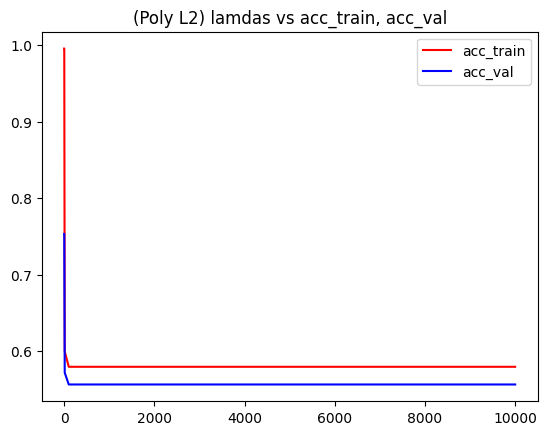

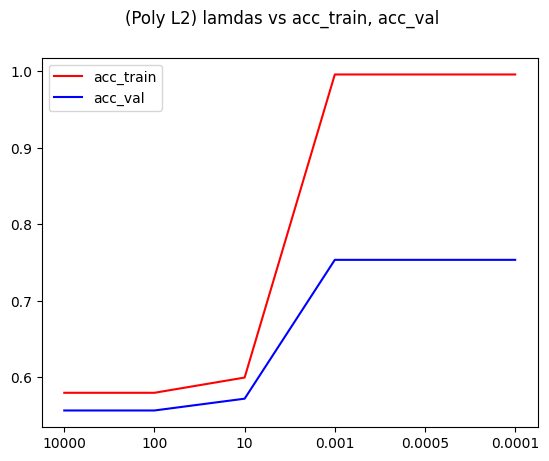

In [13]:
acc_train = []
acc_val = []
weights = []
recall = []
prec = []
specific_result = results
print(specific_result)
for i in range(len(results)):
    acc_train.append(specific_result[i][0]["acc_train"])
    acc_val.append(specific_result[i][0]["acc_val"])
    weights.append(specific_result[i][0]["weights"])
    recall.append(specific_result[i][0]["recal"][0])
    prec.append(specific_result[i][0]["prec"][0])

subsets=[str(x) for x in lmdas]


# print(acc_train)
plt.title("(Poly L2) lamdas vs acc_train, acc_val")
# plt.scatter(lmdas, l1acc_train, color='red', label="acc_train")
# plt.scatter(lmdas, l1acc_val, color='blue', label="acc_val")
plt.plot(lmdas, acc_train, color='red', label = "acc_train")
plt.plot(lmdas, acc_val, color='blue', label = "acc_val")
plt.legend()
plt.show()

fig = plt.figure()
fig.suptitle("(Poly L2) lamdas vs acc_train, acc_val")
ax = fig.add_subplot(111)
ax.plot(subsets, acc_train, color='red', label = "acc_train")
ax.plot(subsets, acc_val, color='blue', label = "acc_val")
plt.legend()

# plt.title("(Linear) lamdas vs recall, precision")
# plt.plot(lmdas, recall, color='purple',label="recall")
# plt.plot(lmdas, prec, color='yellow', label="precision")
# plt.legend()
# plt.show()

# fig = plt.figure()
# fig.suptitle("(Poly L2) lamdas vs recall, precision")
# ax = fig.add_subplot(111)
# ax.plot(subsets, recall, color='purple',label="recall")
# ax.plot(subsets, prec, color='yellow', label="precision")
# plt.legend()